In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import os
from torch.utils.data import Dataset
from PIL import Image
import healpy as hp
import tensorflow_graphics.geometry.transformation as tfg
from torchvision import transforms
from ipdf import IPDF
from torch.utils.data import DataLoader
from train import DATA_DIR, DEVICE, PARAMS_F
from bingham_vis.bc_dataloader import BottleCapDataset

print(PARAMS_F)

DATA_DIR = "/home/tkaminsky/Desktop/bingham/bingham_vis/bc_data_simple"
NUMBER_QUERIES = 200000
inches_per_subplot = 4
ds_path = "bingham_vis/bottle_cap_data"
subset = ['Arrow', 'Circle', 'Cross', 'Diamond', 'Hexagon', 'Key', 'Line', 'Pentagon', 'U']
subset =['Line']
USE_BC = True
NEG_SAMPLES = 1


best_params_bc.pth


In [28]:
def visualize_model_output(model_head,
                           images,
                           rotation_matrices_gt=None):
  """Display distributions over SO(3).
  Args:
    vision_model: The model which produces a feature vector to hand to IPDF.
    model_head: The IPDF model.
    images: A list of images.
    rotation_matrices_gt: A list of [N, 3, 3] tensors, representing the ground
      truth rotation matrices corresponding to the images.
  Returns:
    A tensor of images to output via Tensorboard.
  """
  return_images = []
  num_to_display = 5

  # vision_description = vision_model(torch.stack(images, 0), training=False)

  query_rotations, probabilities = model_head.output_pdf(images)
  inches_per_subplot = 4
  canonical_rotation = np.float32(Rotation.from_euler([0.2*3]).as_matrix())
  for image_index in range(num_to_display):
    fig = plt.figure(figsize=(3*inches_per_subplot, inches_per_subplot))
    gs = fig.add_gridspec(1, 3)
    fig.add_subplot(gs[0, 0])
    plt.imshow(images[image_index])
    plt.axis('off')
    ax2 = fig.add_subplot(gs[0, 1:], projection='mollweide')
    return_fig = visualize_so3_probabilities(
        query_rotations,
        probabilities[image_index],
        rotation_matrices_gt[image_index],
        ax=ax2,
        fig=fig,
        display_threshold_probability=1e-2 / query_rotations.shape[0],
        canonical_rotation=canonical_rotation)
    return_images.append(return_fig)
  return torch.concat(return_images, 0)


def visualize_so3_probabilities(rotations,
                                probabilities,
                                rotations_gt=None,
                                ax=None,
                                fig=None,
                                display_threshold_probability=0,
                                to_image=True,
                                show_color_wheel=True,
                                canonical_rotation=np.eye(3)):
  """Plot a single distribution on SO(3) using the tilt-colored method.
  Args:
    rotations: [N, 3, 3] tensor of rotation matrices
    probabilities: [N] tensor of probabilities
    rotations_gt: [N_gt, 3, 3] or [3, 3] ground truth rotation matrices
    ax: The matplotlib.pyplot.axis object to paint
    fig: The matplotlib.pyplot.figure object to paint
    display_threshold_probability: The probability threshold below which to omit
      the marker
    to_image: If True, return a tensor containing the pixels of the finished
      figure; if False return the figure itself
    show_color_wheel: If True, display the explanatory color wheel which matches
      color on the plot with tilt angle
    canonical_rotation: A [3, 3] rotation matrix representing the 'display
      rotation', to change the view of the distribution.  It rotates the
      canonical axes so that the view of SO(3) on the plot is different, which
      can help obtain a more informative view.
  Returns:
    A matplotlib.pyplot.figure object, or a tensor of pixels if to_image=True.
  """
  def _show_single_marker(ax, rotation, marker, edgecolors=True,
                          facecolors=False):
    eulers = Rotation.from_matrix(rotation).as_euler('xyz')
    xyz = rotation[:, 0]
    tilt_angle = eulers[0]
    longitude = np.arctan2(xyz[0], -xyz[1])
    latitude = np.arcsin(xyz[2])

    color = cmap(0.5 + tilt_angle / 2 / np.pi)
    ax.scatter(longitude, latitude, s=2500,
               edgecolors=color if edgecolors else 'none',
               facecolors=facecolors if facecolors else 'none',
               marker=marker,
               linewidth=4)

  if ax is None:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='mollweide')
  if rotations_gt is not None and len(rotations_gt.shape) == 2:
    rotations_gt = rotations_gt.unsqueeze(0)

  print("Rotations shape: ", rotations.shape)
  print("Canonical rotation: ", canonical_rotation.shape)
  display_rotations = rotations @ canonical_rotation
  cmap = plt.cm.hsv
  scatterpoint_scaling = 4e3

  eulers_queries = Rotation.from_matrix(display_rotations).as_euler('xyz')
  xyz = display_rotations[:, :, 0]
  tilt_angles = eulers_queries[:, 0]

  longitudes = np.arctan2(xyz[:, 0], -xyz[:, 1])
  latitudes = np.arcsin(xyz[:, 2])

  which_to_display = (probabilities > display_threshold_probability)

  if rotations_gt is not None:
    # The visualization is more comprehensible if the GT
    # rotation markers are behind the output with white filling the interior.
    display_rotations_gt = rotations_gt @ canonical_rotation

    for rotation in display_rotations_gt:
      _show_single_marker(ax, rotation, 'o')
    # Cover up the centers with white markers
    for rotation in display_rotations_gt:
      _show_single_marker(ax, rotation, 'o', edgecolors=False,
                          facecolors='#ffffff')
  

  # Display the distribution
  ax.scatter(
      longitudes[which_to_display],
      latitudes[which_to_display],
      s=scatterpoint_scaling * probabilities[which_to_display],
      c=cmap(0.5 + tilt_angles[which_to_display] / 2. / np.pi))

  ax.grid()
  ax.set_xticklabels([])
  ax.set_yticklabels([])

  if show_color_wheel:
    # Add a color wheel showing the tilt angle to color conversion.
    ax = fig.add_axes([0.86, 0.17, 0.12, 0.12], projection='polar')
    theta = np.linspace(-3 * np.pi / 2, np.pi / 2, 200)
    radii = np.linspace(0.4, 0.5, 2)
    _, theta_grid = np.meshgrid(radii, theta)
    colormap_val = 0.5 + theta_grid / np.pi / 2.
    ax.pcolormesh(theta, radii, colormap_val.T, cmap=cmap)
    ax.set_yticklabels([])
    ax.set_xticklabels([r'90$\degree$', None,
                        r'180$\degree$', None,
                        r'270$\degree$', None,
                        r'0$\degree$'], fontsize=14)
    ax.spines['polar'].set_visible(False)
    plt.text(0.5, 0.5, 'Tilt', fontsize=14,
             horizontalalignment='center',
             verticalalignment='center', transform=ax.transAxes)
  plt.show()
  if to_image:
    return None
  else:
    return fig

In [38]:

def compare_rotations():
    # Replicating code here: https://github.com/google-research/google-research/blob/4d906a25489bb7859a88d982a6c5e68dd890139b/implicit_pdf/models.py#L380
    # with SciPy and NumPy functions.
    recursion_level = 1
    number_per_side = 2**recursion_level
    number_pix = hp.nside2npix(number_per_side)
    s2_points = hp.pix2vec(number_per_side, np.arange(number_pix))
    s2_points = np.stack([*s2_points], 1)

    azimuths = np.arctan2(s2_points[:, 1], s2_points[:, 0])
    polars = np.arccos(s2_points[:, 2])
    tilts = np.linspace(0, 2 * np.pi, 6 * 2**recursion_level, endpoint=False)

    # IPDF.
    zeros = np.zeros(number_pix)
    R1s_tf = tfg.rotation_matrix_3d.from_euler(np.stack([azimuths, zeros, zeros], 1))
    R2s_tf = tfg.rotation_matrix_3d.from_euler(np.stack([zeros, zeros, polars], 1))
    R1_R2s_tf = R1s_tf @ R2s_tf
    Rs_tf = []
    for tilt in tilts:
        R3_tf = tfg.rotation_matrix_3d.from_euler([[tilt, 0, 0]])
        R1_R2s_R3_tf = R1_R2s_tf @ R3_tf
        Rs_tf.append(R1_R2s_R3_tf)

    Rs_tf = np.concatenate(Rs_tf)

    # Mine.
    R1s_sp = Rotation.from_euler("X", azimuths).as_matrix()
    R2s_sp = Rotation.from_euler("Z", polars).as_matrix()
    R3s_sp = Rotation.from_euler("X", tilts).as_matrix()
    Rs_sp = np.einsum("bij,tjk->tbik", R1s_sp @ R2s_sp, R3s_sp).reshape(-1, 3, 3)

    assert np.all(np.isclose(Rs_tf, Rs_sp))


def generate_healpix_grid(recursion_level=None, size=None):
    # See: # https://github.com/google-research/google-research/blob/4d906a25489bb7859a88d982a6c5e68dd890139b/implicit_pdf/models.py#L380.
    # I replaced TensorFlow functions with functions from SciPy and NumPy.
    assert not (recursion_level is None and size is None)
    if size:
        recursion_level = max(int(np.round(np.log(size / 72.0) / np.log(8.0))), 0)

    number_per_side = 2**recursion_level
    number_pix = hp.nside2npix(number_per_side)
    s2_points = hp.pix2vec(number_per_side, np.arange(number_pix))
    s2_points = np.stack([*s2_points], 1)

    azimuths = np.arctan2(s2_points[:, 1], s2_points[:, 0])
    polars = np.arccos(s2_points[:, 2])
    tilts = np.linspace(0, 2 * np.pi, 6 * 2**recursion_level, endpoint=False)

    R1s = Rotation.from_euler("X", azimuths).as_matrix()
    R2s = Rotation.from_euler("Z", polars).as_matrix()
    R3s = Rotation.from_euler("X", tilts).as_matrix()

    Rs = np.einsum("bij,tjk->tbik", R1s @ R2s, R3s).reshape(-1, 3, 3)
    return Rs


def main():
    # See: https://github.com/google-research/google-research/blob/4d906a25489bb7859a88d982a6c5e68dd890139b/implicit_pdf/models.py#L272
    # and Section 3.4/Figure 2.
    grid_sizes = 72 * 8 ** np.arange(7)
    size = grid_sizes[np.argmin(np.abs(np.log(NUMBER_QUERIES) - np.log(grid_sizes)))]
    size = 2359296
    size = 18874368
    print("GRid sizes: ", grid_sizes)
    print("Shape of size: ", size)
    R_grid = generate_healpix_grid(size=size)
    R_grid = torch.from_numpy(R_grid).float().to(DEVICE)
    print("Shape of R_grid: ", R_grid.shape)
    model = IPDF().to(DEVICE)
    model.load_state_dict(torch.load(PARAMS_F))
    model.eval()

    #valid_dataset = SymmetricSolidsDataset(DATA_DIR, "test", SYMSOL_I, 1)

    if USE_BC:
        valid_dataset = BottleCapDataset(ds_path, subset, NEG_SAMPLES, False, type='test')
    #valid_dataset = BottleCapDataset(DATA_DIR, "Circle_cube", 1)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=1)

    preprocess_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                transforms.Resize((224, 224))
            ]
        )
    # Load sample 2 from sample2.png
    # sample2 = Image.open("sample2.png")
    # # Convert to RGB.
    # sample2 = sample2.convert("RGB")

    # sample2 = preprocess_transforms(sample2)
    # sample2 = sample2.unsqueeze(0).to(DEVICE)
    # undo_preprocess_transforms = transforms.Compose(
    #         [
    #             transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225]),
    #         ]
    #     )

    valid_loss = 0.0
    with torch.no_grad():
        for (imgs, Rs_fake_Rs) in valid_loader:
            # See: https://github.com/google-research/google-research/blob/4d906a25489bb7859a88d982a6c5e68dd890139b/implicit_pdf/models.py#L154.
            R = Rs_fake_Rs[0, 0].reshape(3, 3).float().to(DEVICE)
            R_delta = R_grid[0].T @ R
            R_grid_old = R_grid @ R_delta
            R_grid_new = (R_grid @ R_delta).reshape(1, -1, 9)

            R_grid_old = R_grid
            R_grid_new = R_grid.reshape(1, -1, 9)
            #probs = model(imgs.to(DEVICE), R_grid_new.to(DEVICE))
            #imgs = sample2
            print(imgs.shape)

            query_rotations, probabilities = model.output_pdf(imgs.to(DEVICE), R_grid_new.to(DEVICE))

            query_rotations = query_rotations.cpu().numpy()
            probabilities = probabilities.cpu().numpy()

            fig = plt.figure(figsize=(3*inches_per_subplot, inches_per_subplot))
            gs = fig.add_gridspec(1, 3)
            fig.add_subplot(gs[0, 0])
            plt.imshow(imgs[0].permute(1,2,0).cpu().numpy())
            plt.axis('off')
            ax2 = fig.add_subplot(gs[0, 1:], projection='mollweide')
            visualize_so3_probabilities(
                R_grid_old.cpu().numpy(),
                probabilities[0],
                ax=ax2,
                fig=fig,
                display_threshold_probability=1e-4 / query_rotations.shape[0],)
            plt.show()



            # loss = -torch.log(probabilities[0]).mean()
            # valid_loss += loss.item()

    valid_loss /= len(valid_dataset)
    print(valid_loss)


main()

GRid sizes:  [      72      576     4608    36864   294912  2359296 18874368]
Shape of size:  18874368
Shape of R_grid:  torch.Size([18874368, 3, 3])
torch.Size([1, 3, 256, 256])


OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 GiB (GPU 0; 23.66 GiB total capacity; 4.72 GiB already allocated; 15.78 GiB free; 6.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

[2087101 2099266]
[0.45626226 0.38391414]


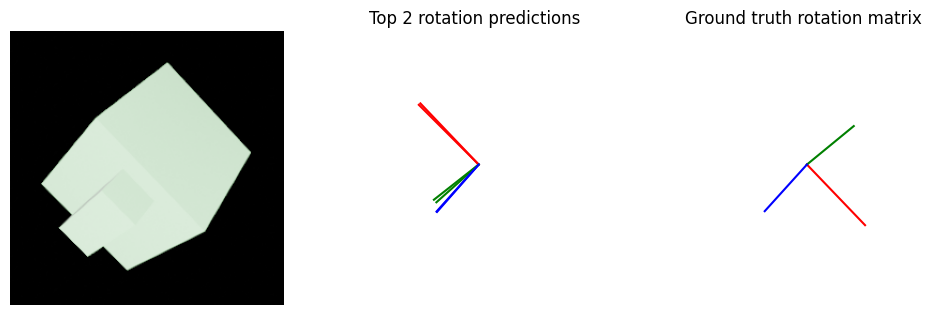

[1344782 2206414]
[0.81894845 0.17919743]


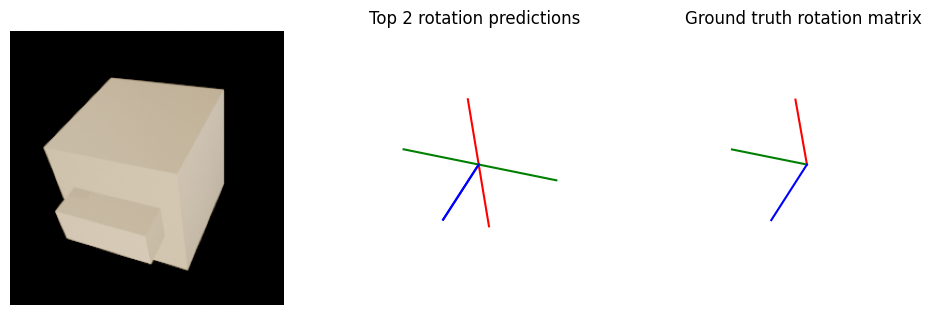

[935839 256093]
[0.7646801  0.12790693]


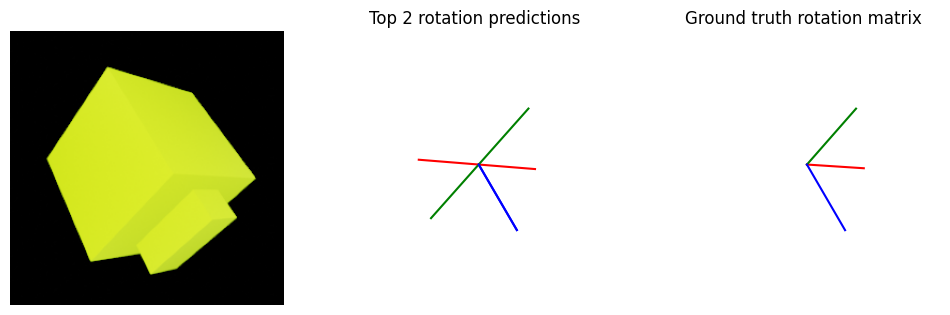

[2005439 2017598]
[0.493071   0.30427352]


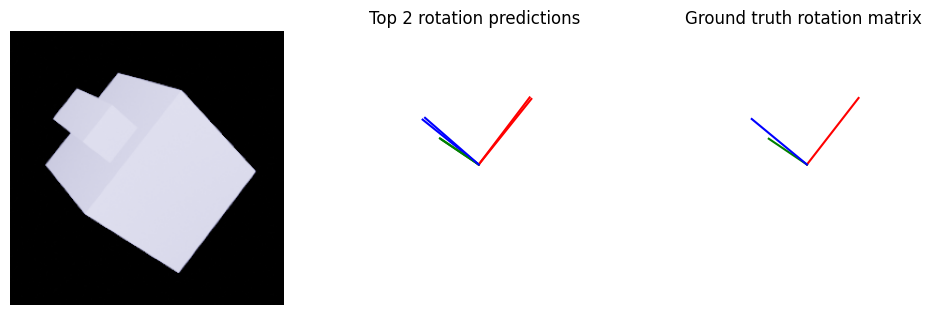

[1558180 1558052]
[0.5535397  0.19680609]


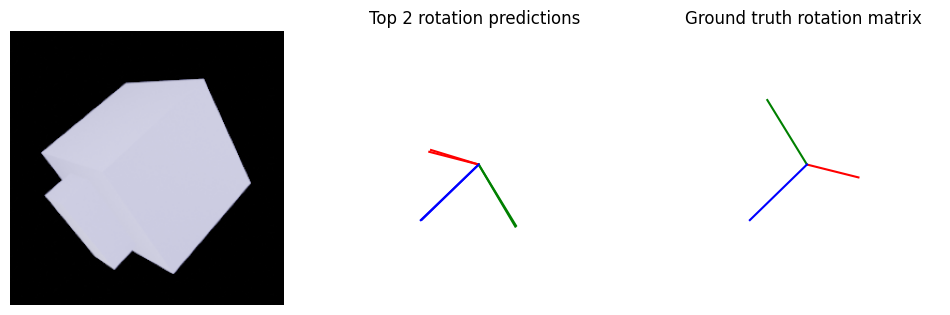

[2028136 1523068]
[0.38939053 0.27110776]


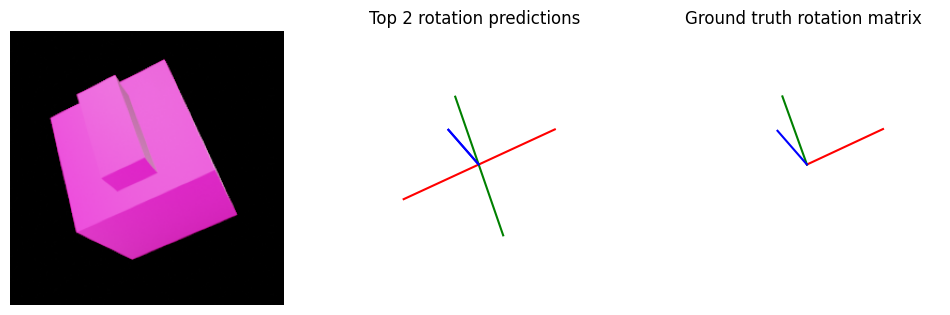

[2132555 1418635]
[0.81702954 0.09594318]


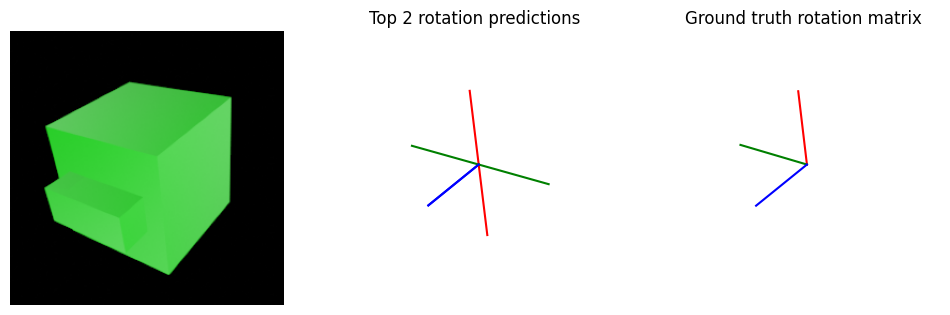

[ 104274 1087634]
[0.58519125 0.18201202]


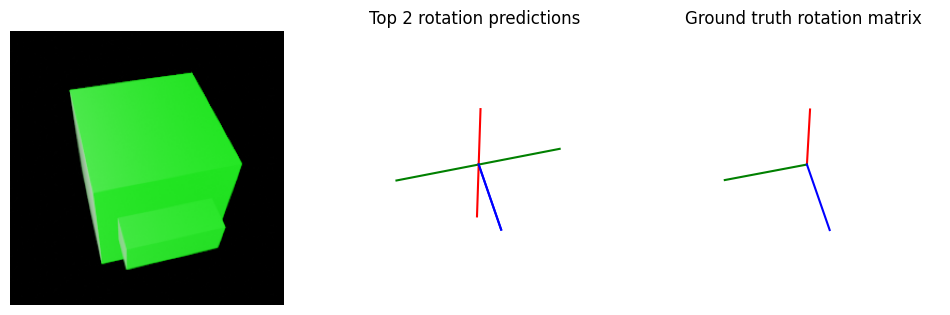

[589769 602167]
[0.90255415 0.09308877]


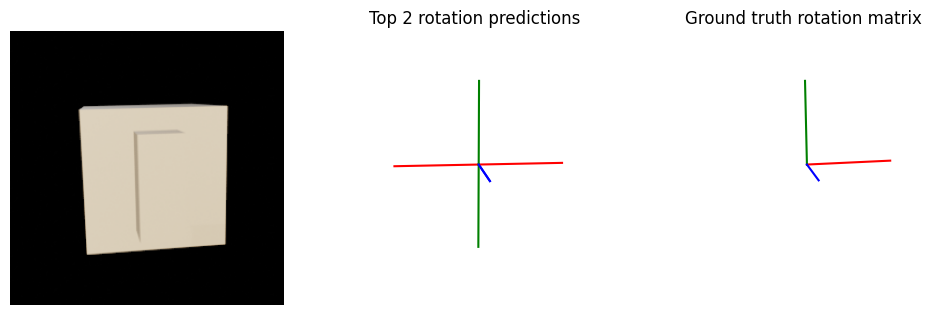

[1031851  160105]
[0.74707925 0.23542713]


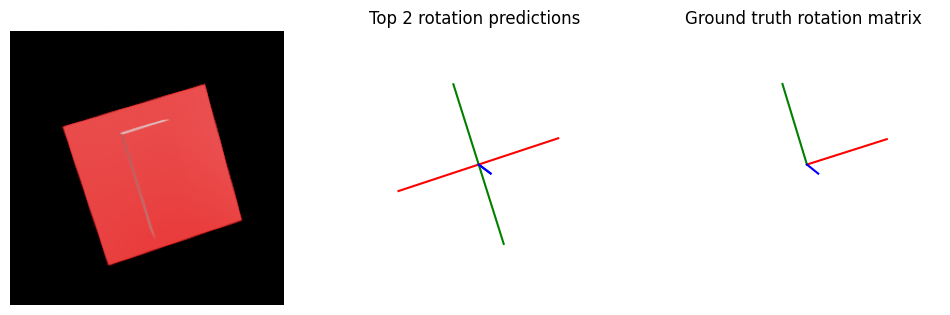

[183841 196189]
[0.4305322 0.3830299]


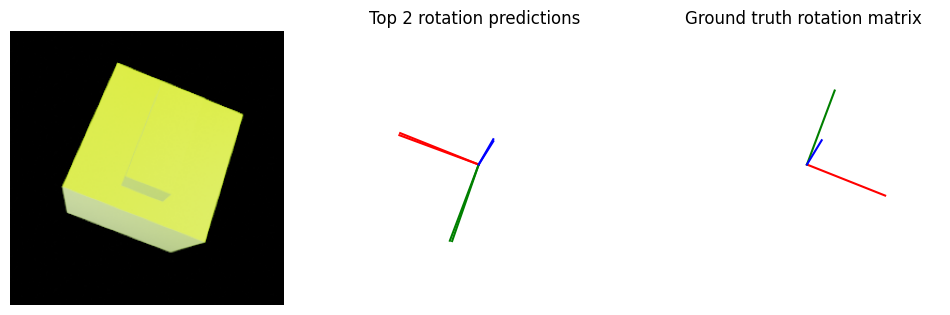

[2092492 2092620]
[0.43341967 0.16489214]


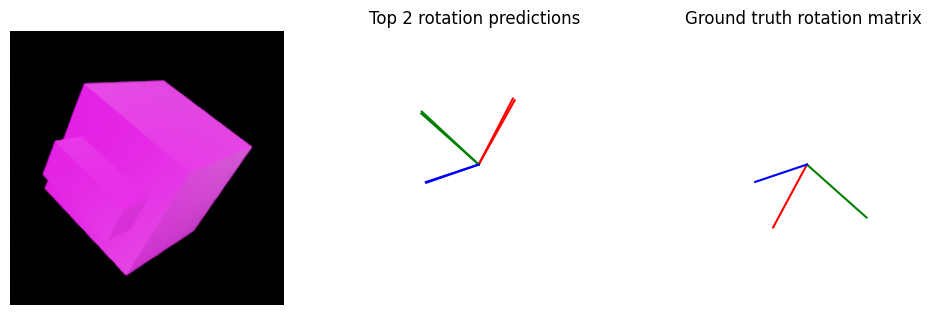

[980327 211623]
[0.95461136 0.01860151]


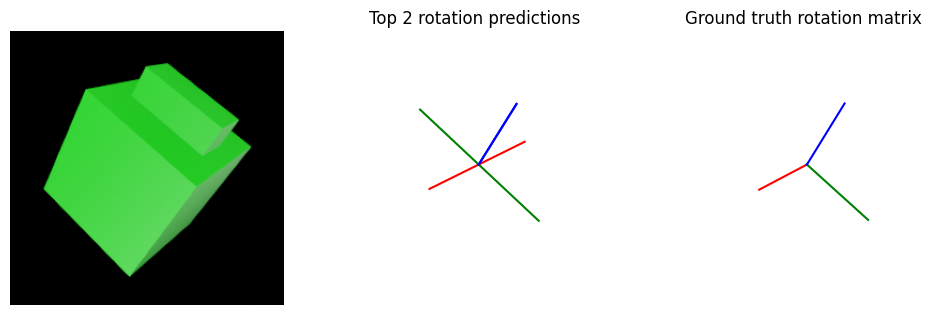

[1881723 1681810]
[0.4360532  0.24680814]


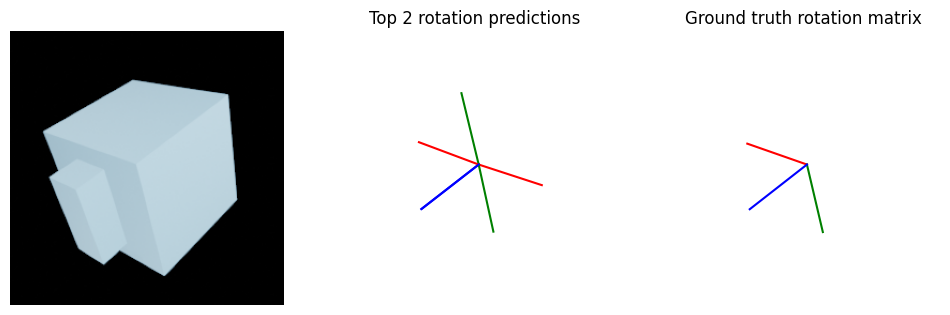

[1743946 1807278]
[0.6920671  0.29833654]


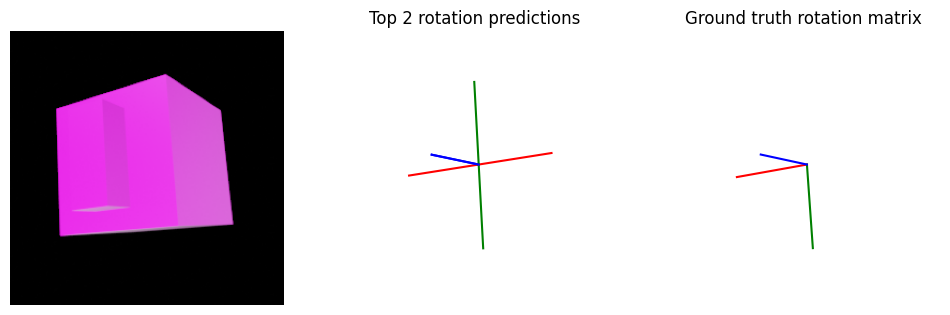

[1315765 1327886]
[0.6029681  0.07658835]


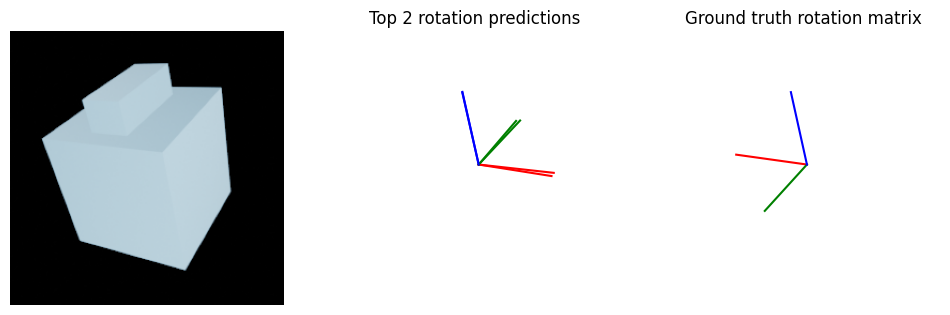

[1213946 2337338]
[0.84177196 0.08905476]


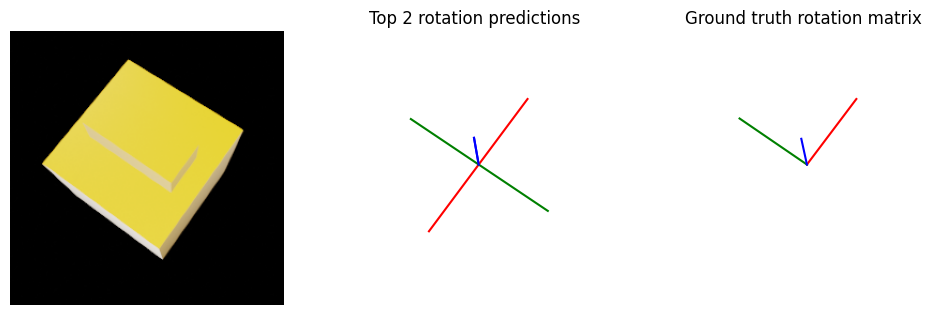

[1996242 1996370]
[0.5786727  0.10375189]


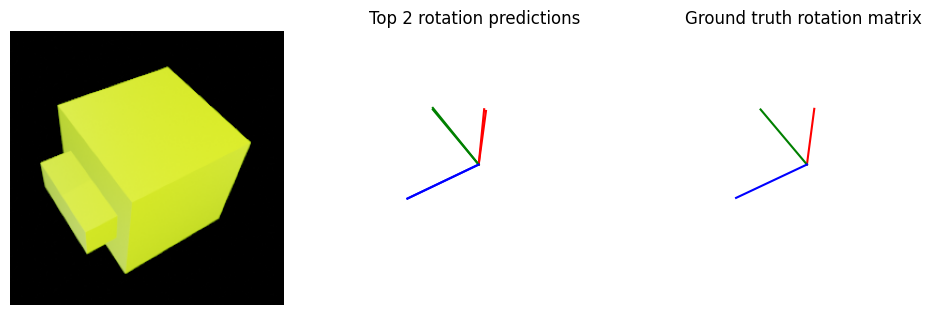

[201295 201423]
[0.5627548  0.11729766]


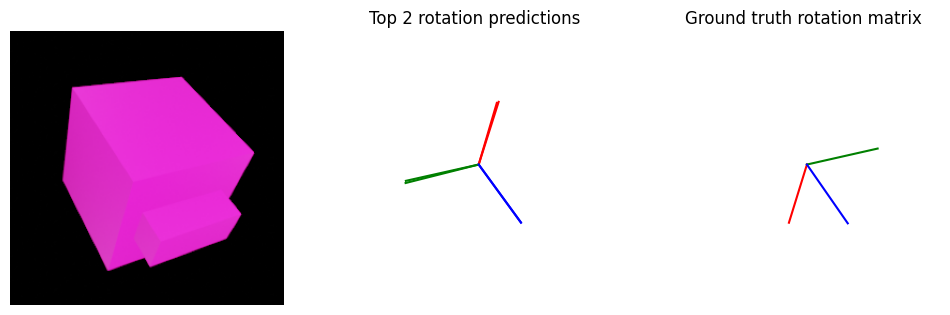

[370363 821597]
[0.5171167 0.3557028]


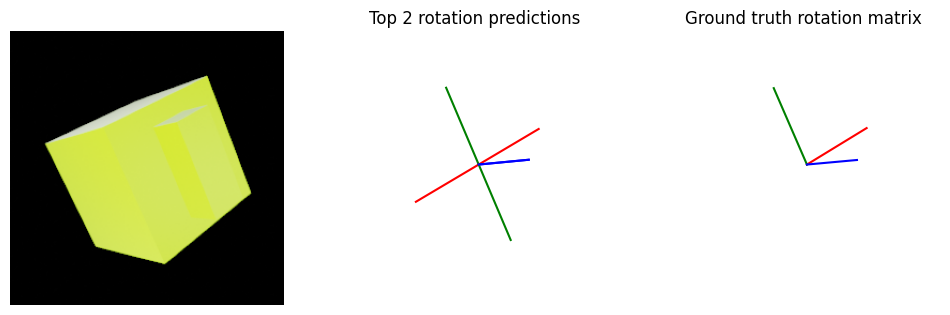

[1336821 2214453]
[0.8970689  0.04858327]


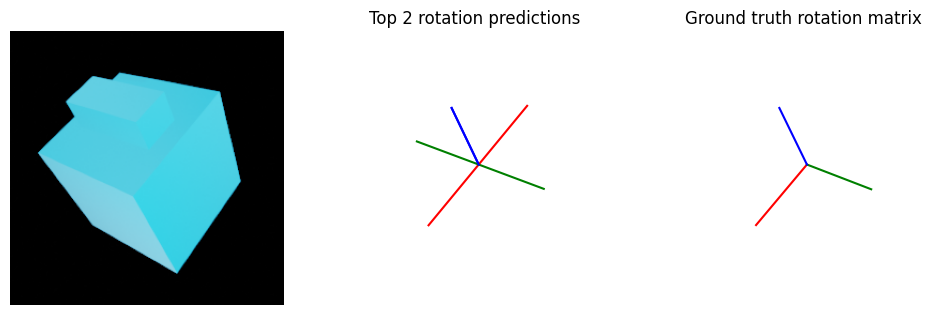

[1045464  134172]
[0.2573564  0.20147623]


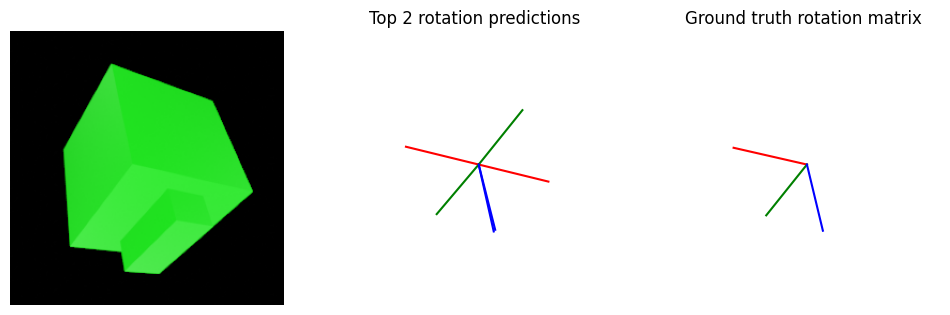

[1348243 2203090]
[0.522514   0.21651174]


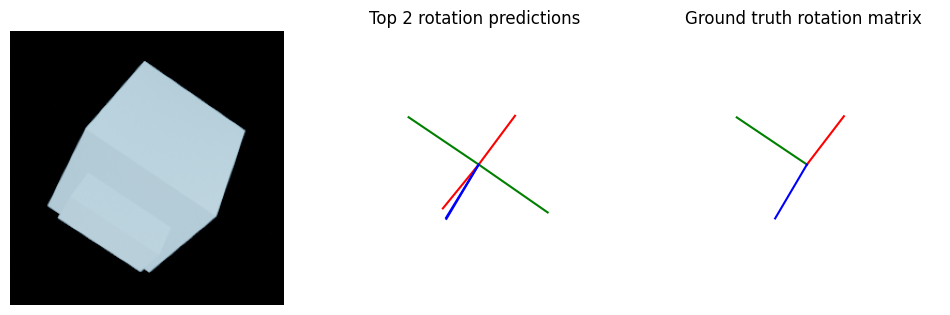

[574697 617257]
[0.73745495 0.16067018]


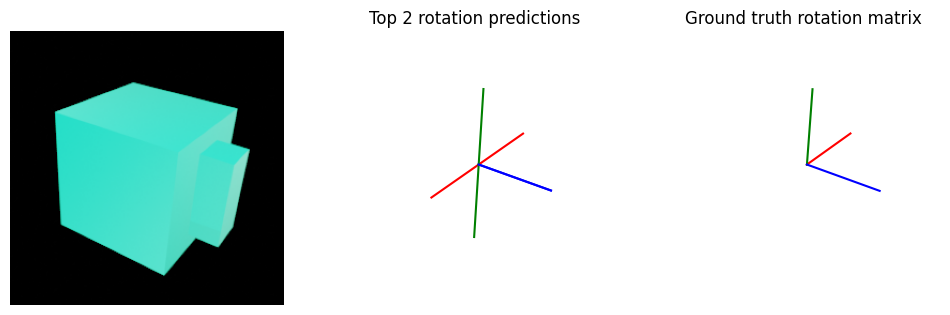

[280506 268217]
[0.658073   0.17214379]


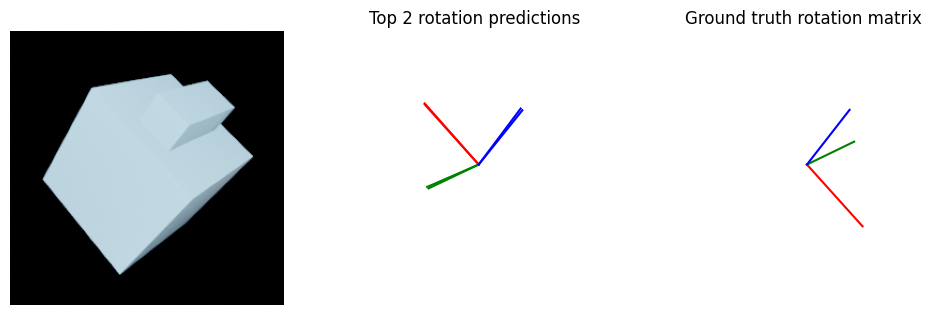

[1197041 1209329]
[0.5034764  0.37655166]


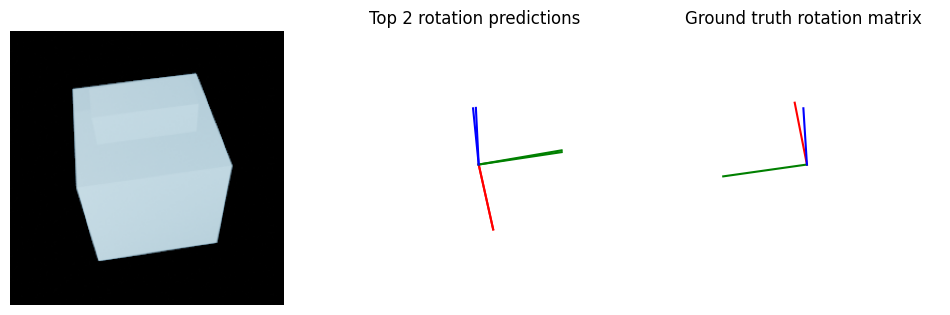

[2246059 1305195]
[0.7867165  0.14918034]


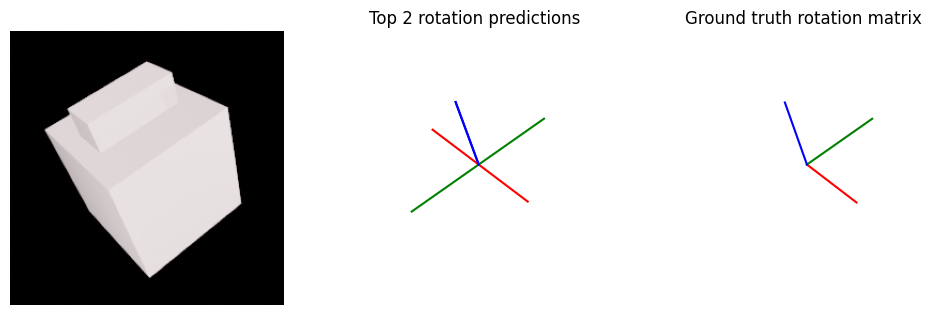

[2192314 1358970]
[0.47100985 0.34232008]


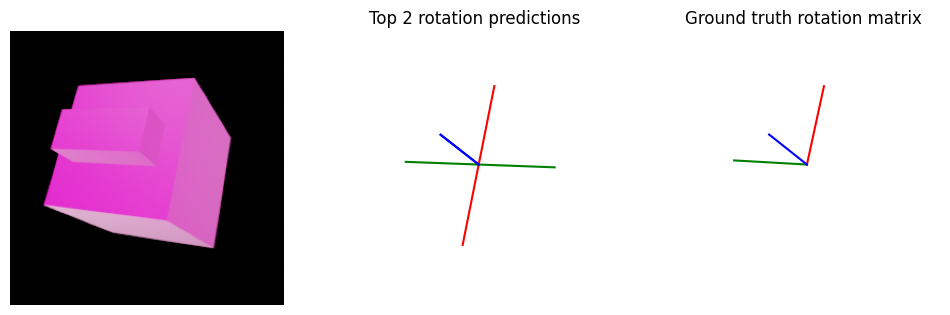

[1095337 1107866]
[0.4519511  0.18482235]


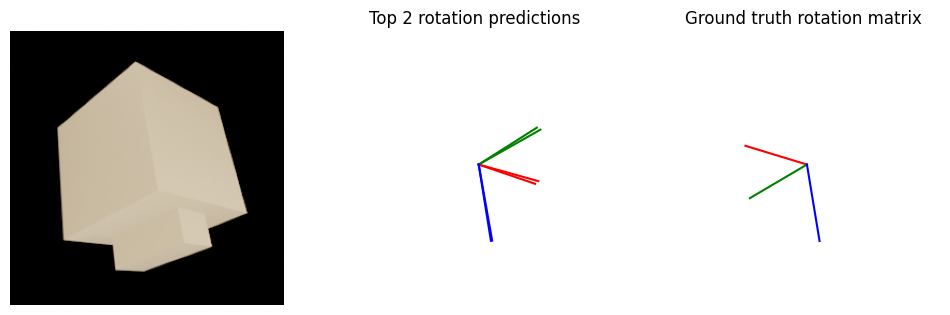

[2273971 2286335]
[0.6722125  0.25247908]


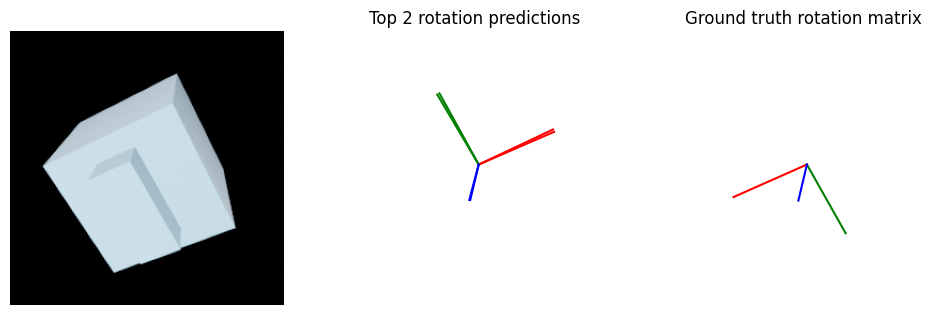

[1035538  156370]
[0.6401809 0.2881558]


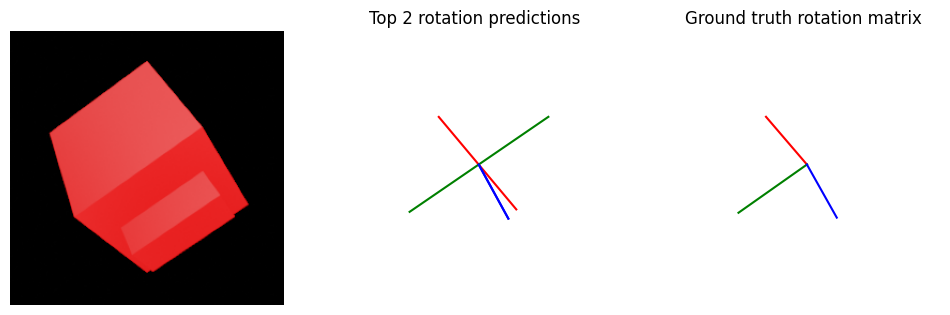

[616229 628516]
[0.7657845  0.08019515]


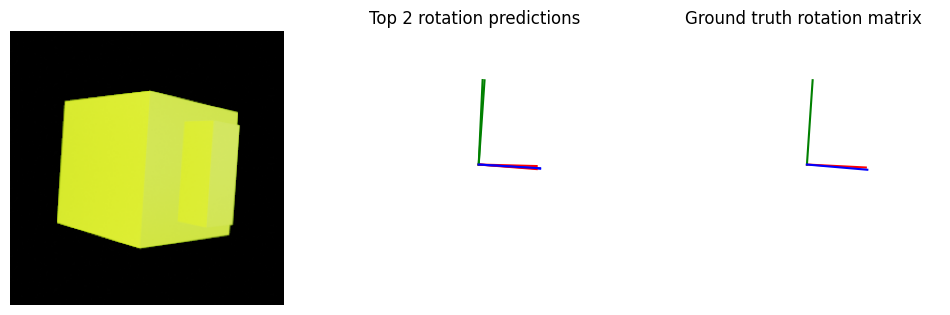

[1402725 2148511]
[0.9183182  0.03847116]


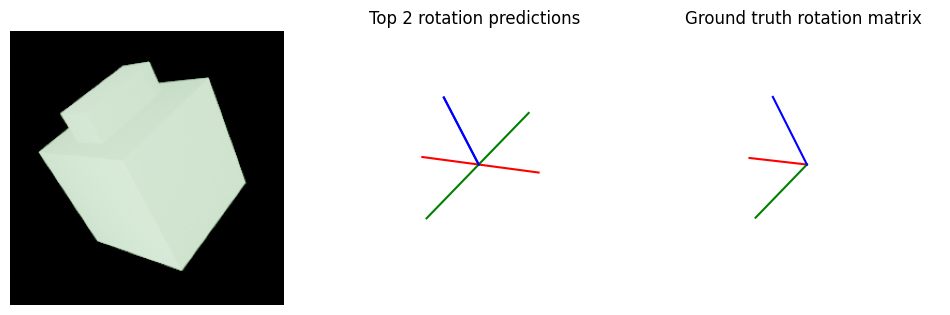

[992268 199501]
[0.28427473 0.22731549]


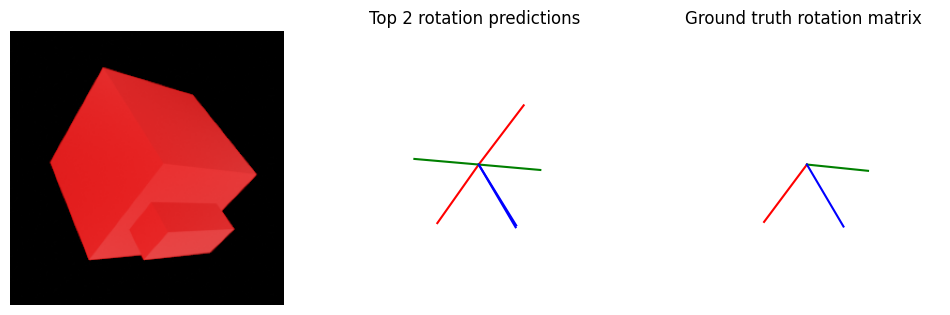

[1230271 2320933]
[0.86969703 0.11501441]


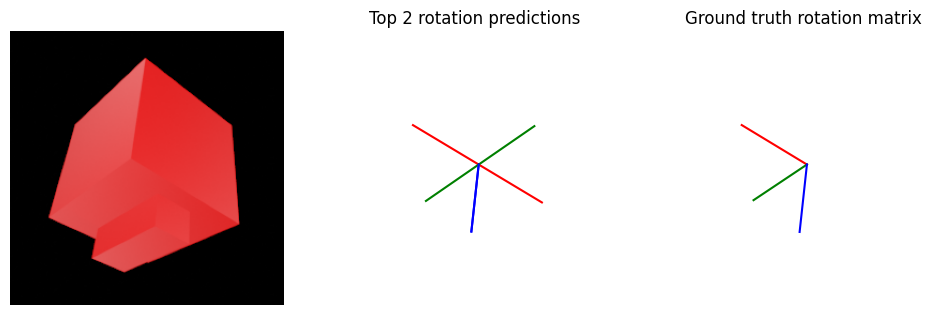

[888195 875907]
[0.9381537  0.03643876]


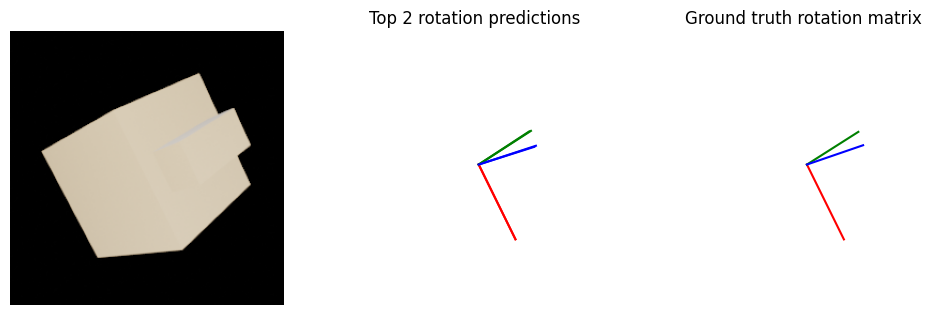

[940163 952323]
[0.6365867  0.17903174]


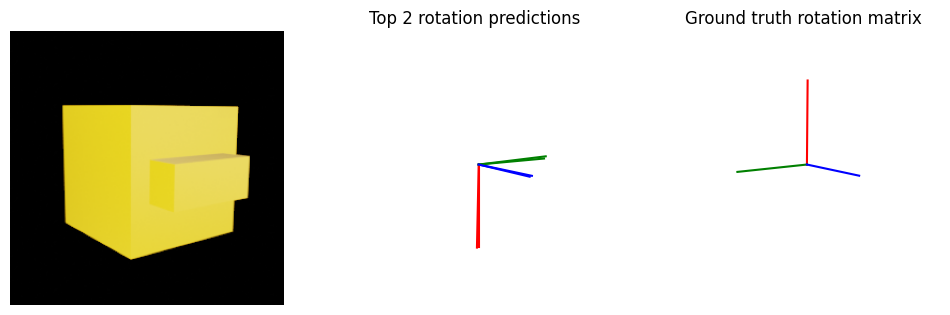

[1967712 1583478]
[0.9492092  0.03686959]


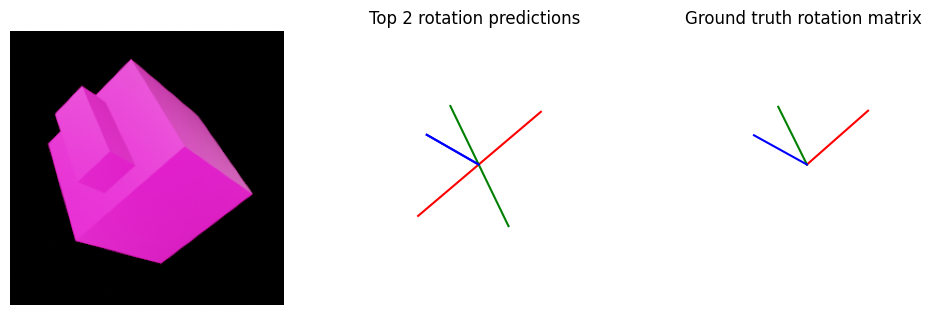

[  81462 1110518]
[0.59249634 0.35188577]


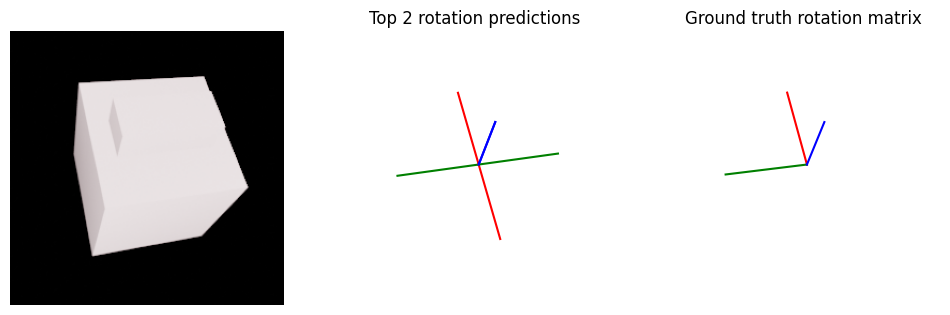

[442541 749399]
[0.5850976  0.40766388]


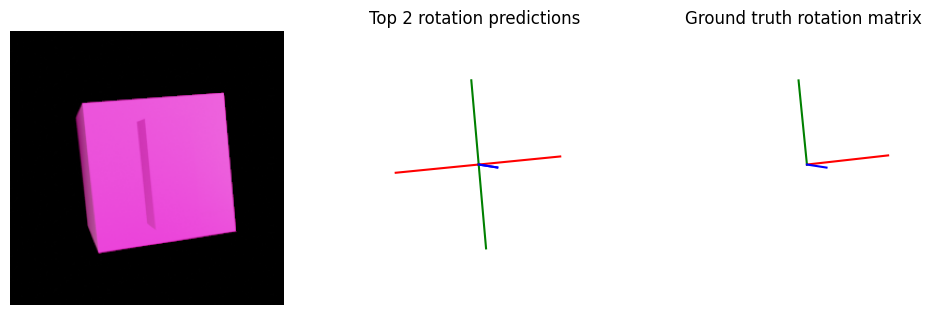

[2057041 2069456]
[0.67707044 0.18710813]


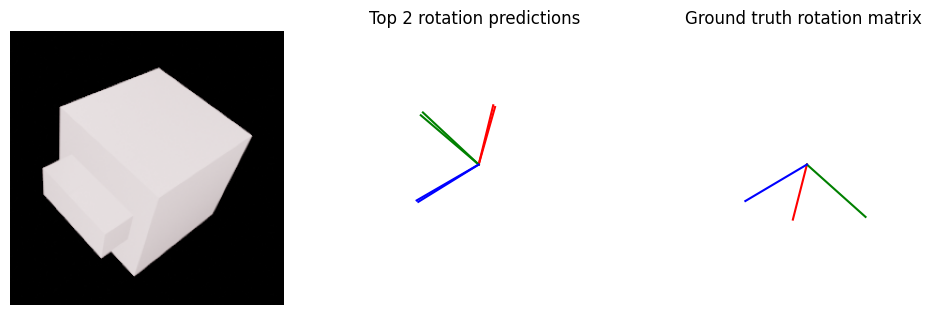

[728842 463050]
[0.49474669 0.35016876]


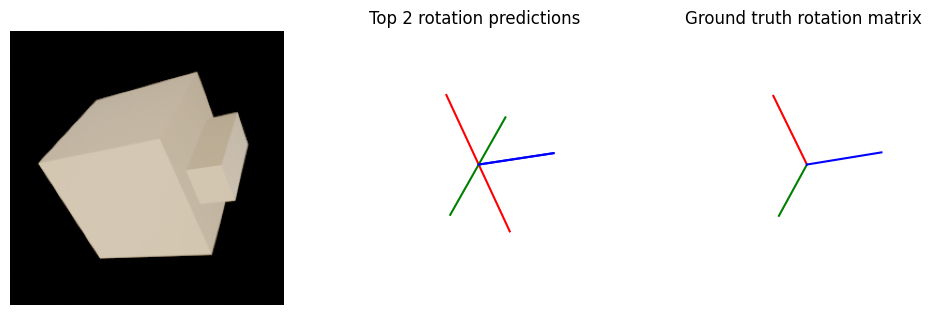

[2035248 1516016]
[0.6994144  0.27450204]


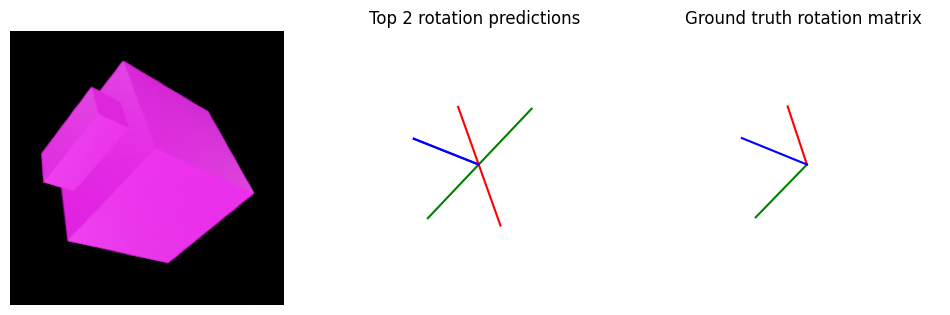

[260653 931437]
[0.38163856 0.17717065]


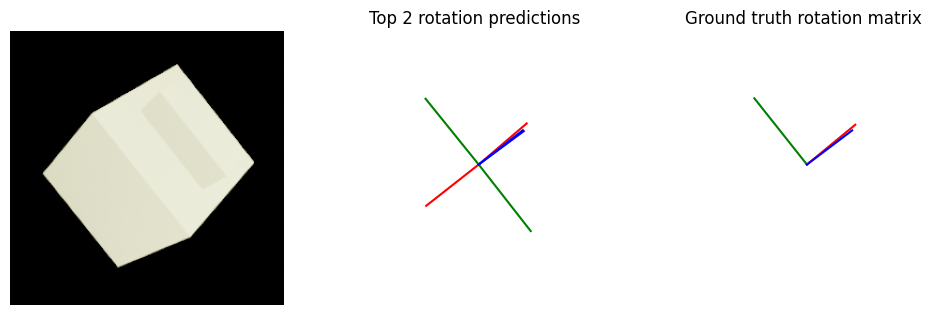

[2241328 2241457]
[0.44028446 0.3379721 ]


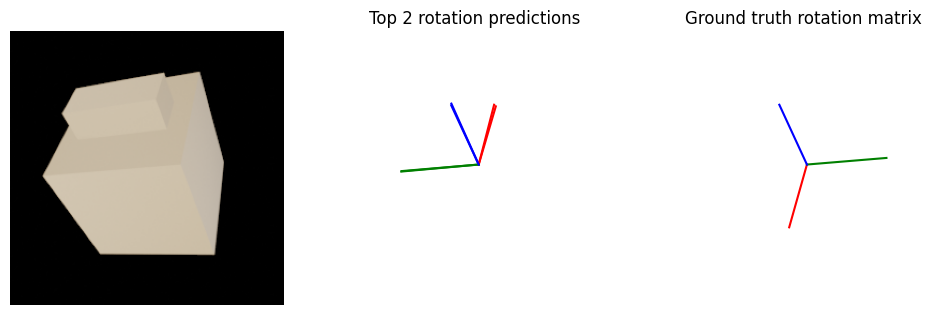

[1365411 2185845]
[0.8054979  0.09409566]


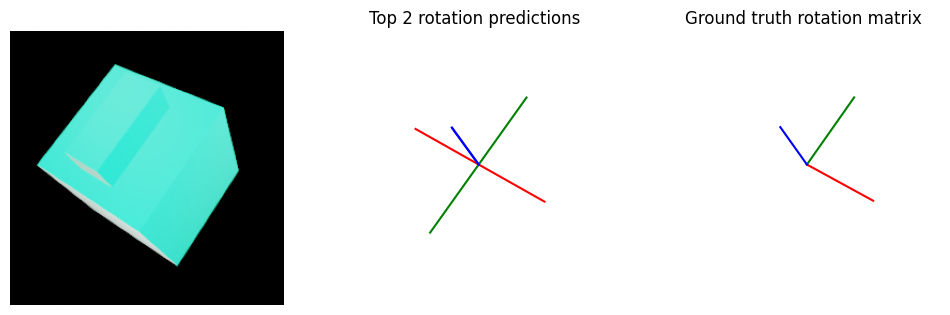

[947882 935595]
[0.42523822 0.1861338 ]


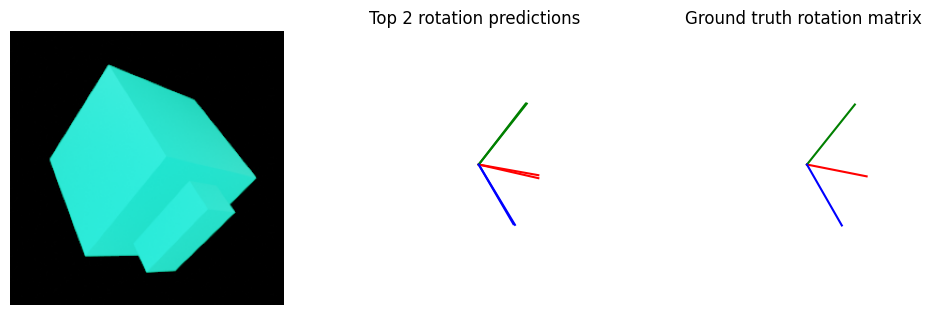

[141616 141488]
[0.8187811  0.13078141]


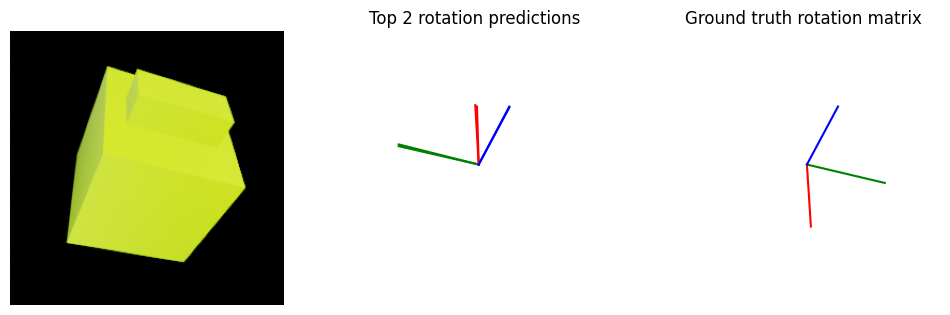

[530723 673380]
[0.42987603 0.28323793]


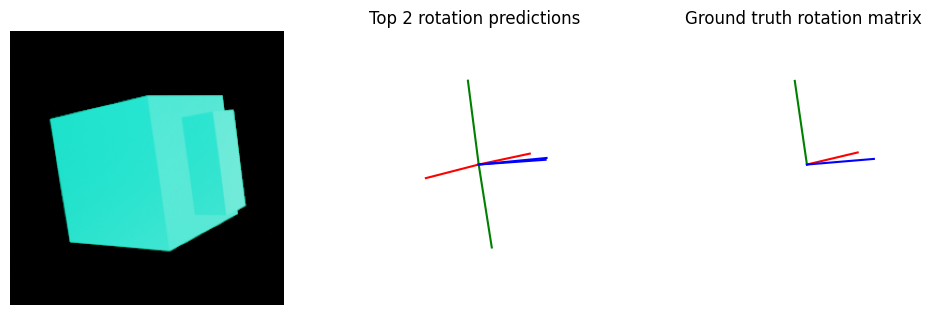

[444194 747853]
[0.49514    0.25202742]


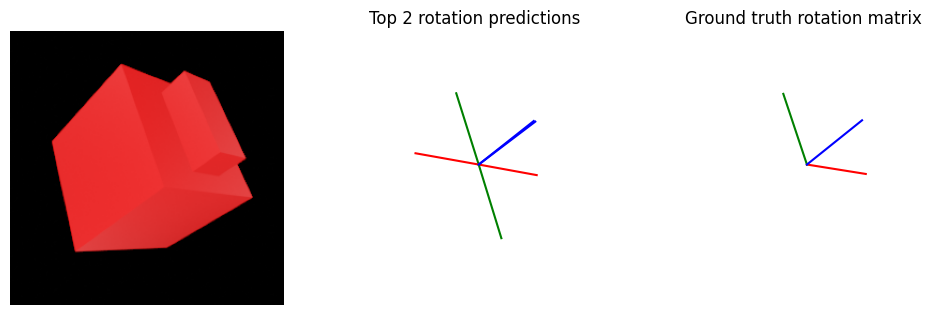

[1731059 1730946]
[0.7862715  0.09916285]


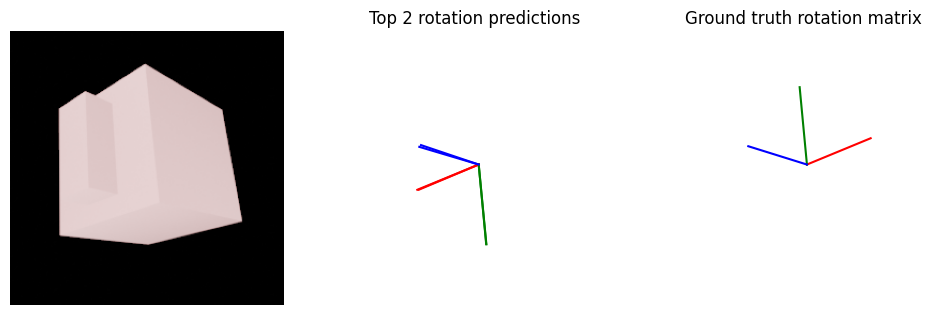

0.0


In [36]:

k = 2

log_highest = []
log_second = []

def vis_orientations():
    # See: https://github.com/google-research/google-research/blob/4d906a25489bb7859a88d982a6c5e68dd890139b/implicit_pdf/models.py#L272
    # and Section 3.4/Figure 2.
    grid_sizes = 72 * 8 ** np.arange(7)
    size = grid_sizes[np.argmin(np.abs(np.log(NUMBER_QUERIES) - np.log(grid_sizes)))]
    size = 2359296
    R_grid = generate_healpix_grid(size=size)
    R_grid = torch.from_numpy(R_grid).float().to(DEVICE)

    model = IPDF().to(DEVICE)
    model.load_state_dict(torch.load(PARAMS_F))
    model.eval()

    #valid_dataset = SymmetricSolidsDataset(DATA_DIR, "test", SYMSOL_I, 1)

    if USE_BC:
        valid_dataset = BottleCapDataset(ds_path, subset, NEG_SAMPLES, False, type='test')
    #valid_dataset = BottleCapDataset(DATA_DIR, "Circle_cube", 1)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=1)
    # Take just the second half of the dataset.
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=1, sampler=torch.utils.data.SubsetRandomSampler(range(len(valid_dataset)//2, len(valid_dataset))))

    preprocess_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                transforms.Resize((224, 224))
            ]
        )

    valid_loss = 0.0
    counter = 0
    with torch.no_grad():
        for (imgs, Rs_fake_Rs) in valid_loader:
            if counter > 50:
                break
            counter += 1
            # See: https://github.com/google-research/google-research/blob/4d906a25489bb7859a88d982a6c5e68dd890139b/implicit_pdf/models.py#L154.
            R = Rs_fake_Rs[0, 0].reshape(3, 3).float().to(DEVICE)
            R_delta = R_grid[0].T @ R
            R_grid_old = R_grid @ R_delta
            R_grid_old = R_grid.cpu()
            R_grid_new = (R_grid @ R_delta).reshape(1, -1, 9)
            #probs = model(imgs.to(DEVICE), R_grid_new.to(DEVICE))
            #imgs = sample2

            query_rotations, probabilities = model.output_pdf(imgs.to(DEVICE), R_grid.reshape(1,-1,9).to(DEVICE))
            # query_rotations, probabilities = model.output_pdf(imgs.to(DEVICE), R_grid_new.to(DEVICE))

            query_rotations = query_rotations.cpu().numpy()
            probabilities = probabilities.cpu().numpy()

            # Grab the top 5 orientations.
            top_5 = np.argsort(probabilities[0])[-k:]
            top_5 = top_5[::-1]
            print(top_5)
            # Print the top 5 probabilities.
            print(probabilities[0][top_5])
            top_five = np.zeros((k, 3,3))
            for i in range(k):
                # top_five[i] = R_grid_old[top_5[i]].cpu().numpy()
                top_five[i] = R_grid_old[top_5[i]].cpu().numpy()

            # For each orientation, rotate the identy matrix by it and display the rotated axes on a plot

            # Add the top two log probabilities to the lists
            log_highest.append(np.log(probabilities[0][top_5[0]]))
            log_second.append(np.log(probabilities[0][top_5[1]]))

            fig = plt.figure(figsize=(3*inches_per_subplot, inches_per_subplot))
            gs = fig.add_gridspec(1, 3)
            fig.add_subplot(gs[0, 0])
            plt.imshow(imgs[0].permute(1,2,0).cpu().numpy())
            plt.axis('off')
            # Ax2 is a 3d plot of the rotated axes.
            ax2 = fig.add_subplot(gs[0, 1], projection='3d')
            ax2.set_xlim(-1, 1)
            ax2.set_ylim(-1, 1)
            ax2.set_zlim(-1, 1)
            ax2.set_xlabel('X')
            ax2.set_ylabel('Y')
            ax2.set_zlabel('Z')

            ax2.view_init(elev=90, azim=-90, roll=0)

            ax2.set_xticklabels([])
            ax2.set_yticklabels([])
            ax2.set_zticklabels([])
            ax2.grid(False)
            # Remove the background.
            ax2.xaxis.pane.fill = False
            ax2.yaxis.pane.fill = False
            ax2.zaxis.pane.fill = False
            # remove axis lines/ticks
            ax2.xaxis.pane.set_edgecolor('w')
            ax2.yaxis.pane.set_edgecolor('w')
            ax2.zaxis.pane.set_edgecolor('w')
            ax2.set_axis_off()
            ax2.grid(False)
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.set_zticks([])

            # Plot a transparent sphere to show the axes.
            # u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
            # x = np.cos(u)*np.sin(v)
            # y = np.sin(u)*np.sin(v)
            # z = np.cos(v)
            # # Plot the sphere without the gridlines
            # ax2.plot_wireframe(x, y, z, color="grey", alpha=0.2)
            ax2.title.set_text(f"Top {k} rotation predictions")

            # Plot the axes.
            I = np.eye(3)
            #I = np.array([[1,0,0],[0,1,0],[0,0,-1]])
            for i in range(k):
                # Rotate the identity matrix by the orientation.
                R = top_five[i]

                I_rotated = R @ I
                # Plot the axes as 3 lines from the origin.
                ax2.plot([0, I_rotated[0, 0]], [0, I_rotated[1, 0]], [0, I_rotated[2, 0]], color="red")
                ax2.plot([0, I_rotated[0, 1]], [0, I_rotated[1, 1]], [0, I_rotated[2, 1]], color="green")
                ax2.plot([0, I_rotated[0, 2]], [0, I_rotated[1, 2]], [0, I_rotated[2, 2]], color="blue")



            # Draw another sphere in the third subplot.
            ax2 = fig.add_subplot(gs[0, 2], projection='3d')
            ax2.set_xlim(-1, 1)
            ax2.set_ylim(-1, 1)
            ax2.set_zlim(-1, 1)
            ax2.set_xlabel('X')
            ax2.set_ylabel('Y')
            ax2.set_zlabel('Z')

            # Change view to be looking down the z axis.
            ax2.view_init(elev=90, azim=-90, roll=0)
            


            # Plot a transparent sphere to show the axes.
            # u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
            # x = np.cos(u)*np.sin(v)
            # y = np.sin(u)*np.sin(v)
            # z = np.cos(v)
            # # Plot the sphere without the gridlines
            # ax2.plot_wireframe(x, y, z, color="grey", alpha=0.2)


            # Grab the ground truth rotation matrix.
            R_gt = Rs_fake_Rs[0, 0].reshape(3, 3).float().to(DEVICE).cpu().numpy()
            # Rotate the identity matrix by the ground truth rotation matrix.
            I_rotated = R_gt @ I
            # Plot the axes as 3 lines from the origin.
            ax2.plot([0, I_rotated[0, 0]], [0, I_rotated[1, 0]], [0, I_rotated[2, 0]], color="red")
            ax2.plot([0, I_rotated[0, 1]], [0, I_rotated[1, 1]], [0, I_rotated[2, 1]], color="green")
            ax2.plot([0, I_rotated[0, 2]], [0, I_rotated[1, 2]], [0, I_rotated[2, 2]], color="blue")

            # Remove the gridlines.
            ax2.set_xticklabels([])
            ax2.set_yticklabels([])
            ax2.set_zticklabels([])
            ax2.grid(False)
            # Remove the background.
            ax2.xaxis.pane.fill = False
            ax2.yaxis.pane.fill = False
            ax2.zaxis.pane.fill = False
            # remove axis lines/ticks
            ax2.xaxis.pane.set_edgecolor('w')
            ax2.yaxis.pane.set_edgecolor('w')
            ax2.zaxis.pane.set_edgecolor('w')
            ax2.set_axis_off()
            ax2.grid(False)
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.set_zticks([])

            # Remove the axis labels.
            
            ax2.title.set_text("Ground truth rotation matrix")
            plt.show()



            # loss = -torch.log(probabilities[0]).mean()
            # valid_loss += loss.item()

    valid_loss /= len(valid_dataset)
    print(valid_loss)

vis_orientations()

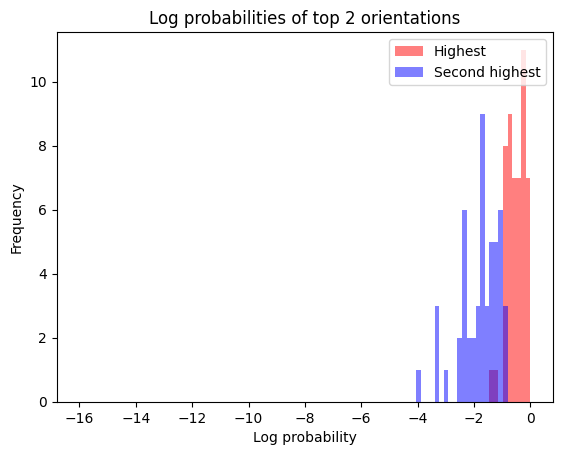

In [37]:
# Plot a histogram of the highest probability in red and the second highest in blue.
bins = np.linspace(-16, 0, 100)
plt.hist(log_highest, bins=bins, color='red', alpha=0.5, label='Highest')
# Plot a histogram of the second highest probability in blue on top of the red histogram.
plt.hist(log_second, bins=bins, color='blue', alpha=0.5, label='Second highest')
plt.legend(loc='upper right')
plt.title(f"Log probabilities of top {2} orientations")
plt.xlabel("Log probability")
plt.ylabel("Frequency")
plt.show()